In [1]:
%matplotlib notebook

In [2]:
from PIL import Image
import cv2 
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact, HBox

import os
import sys
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
# os.path.abspath(os.path.join('..')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from cv2 import aruco
    
from scripts.util import extract_laser, undistort_camera


In [3]:
import glob, os

aruco_samples = []
os.chdir("../res/pose_samples/blank_plane/")
for file in sorted(glob.glob("*"), key=os.path.getmtime):
    aruco_samples.append(file)

In [4]:
def disp_file(path):
    # In OpenCV, images are in BGR
    # In Pillow, images are in RGB 
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    img = cv2.resize(img, (480, 360))
    display(Image.fromarray(img))

# Display cv2 image
def disp_img(cv_img):
#     cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    cv_img = cv2.resize(cv_img, (480, 360))
    display(Image.fromarray(cv_img))

0 aruco_undist_0.png


1 aruco_undist_1.png


2 aruco_undist_2.png


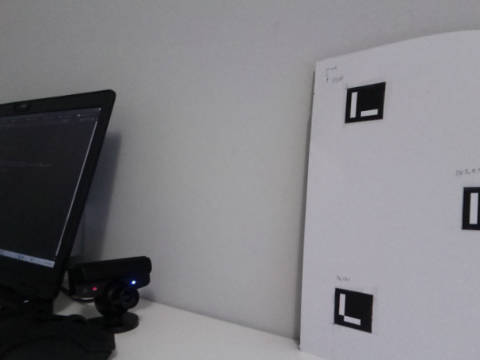

3 aruco_undist_3.png


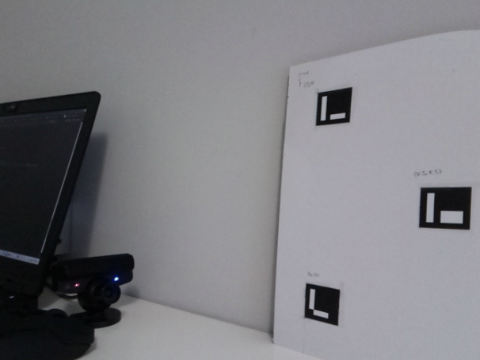

4 aruco_undist_4.png


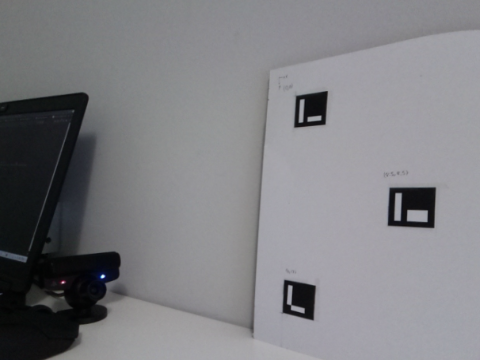

5 aruco_undist_6.png


6 aruco_undist_5.png


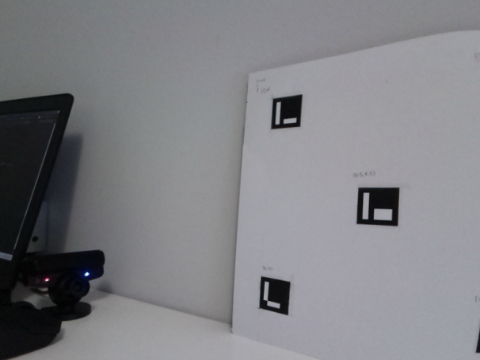

7 aruco_undist_7.png


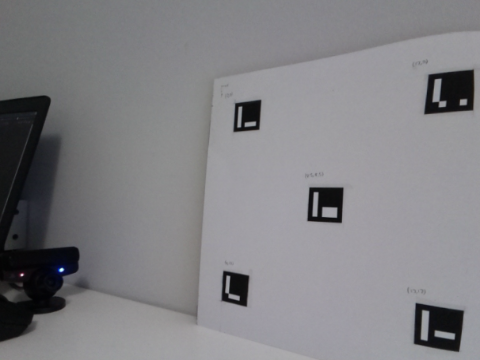

8 aruco_undist_8.png


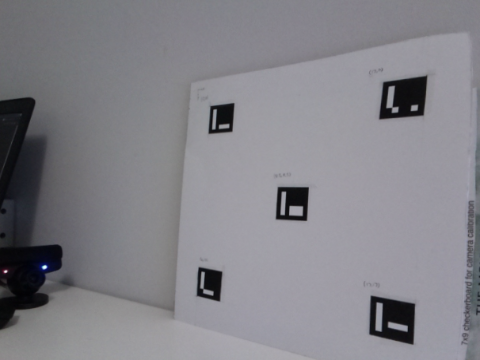

9 aruco_undist_9.png


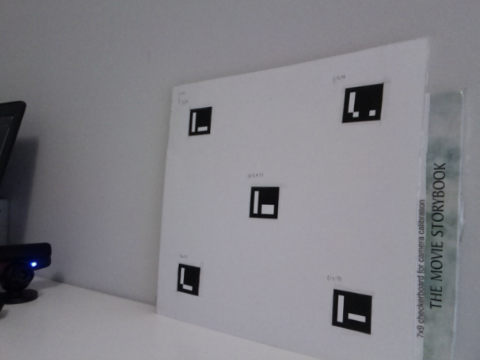

In [5]:
for idx, f in enumerate(aruco_samples):
    print(idx, f)
    disp_file(f)

In [6]:
# marker_31 = cv2.imread(laser_samples[31])
# marker_32 = cv2.imread(laser_samples[32])
# marker_33 = cv2.imread(laser_samples[33])
# marker_34 = cv2.imread(laser_samples[34])

# marker_31 = cv2.cvtColor(marker_31, cv2.COLOR_BGR2GRAY)
# marker_32 = cv2.cvtColor(marker_32, cv2.COLOR_BGR2GRAY)
# marker_33 = cv2.cvtColor(marker_33, cv2.COLOR_BGR2GRAY)
# marker_34 = cv2.cvtColor(marker_34, cv2.COLOR_BGR2GRAY)

In [7]:
# fig, (ax1,ax2, ax3, ax4) = plt.subplots(nrows=1,ncols=4,figsize=(10,2))

# ax1.imshow(marker_31, cmap = plt.get_cmap('gray'))
# ax1.set_title("Image 1")
# ax2.imshow(marker_32, cmap = plt.get_cmap('gray'))
# ax2.set_title("Image 2")
# ax3.imshow(marker_33, cmap = plt.get_cmap('gray'))
# ax3.set_title("Image 3")
# ax4.imshow(marker_34, cmap = plt.get_cmap('gray'))
# ax4.set_title("Image 4")

# plt.show()

In [8]:
imgs = []
for f in aruco_samples:
    img = cv2.imread(f)
    imgs.append(img)

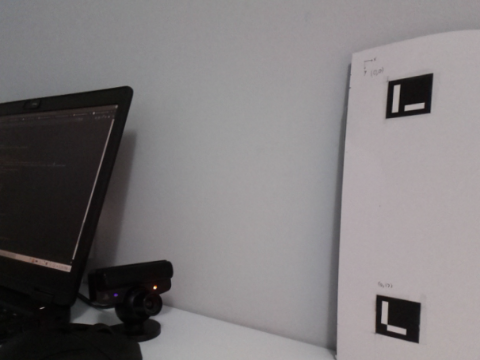

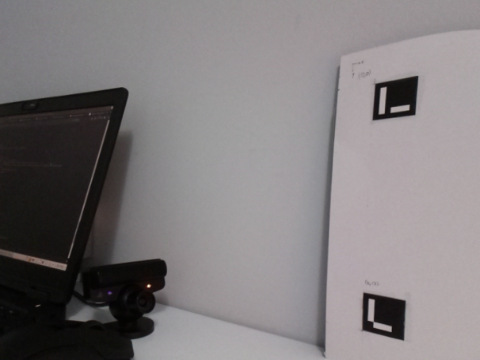

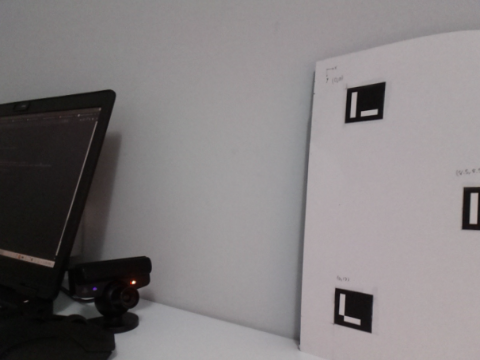

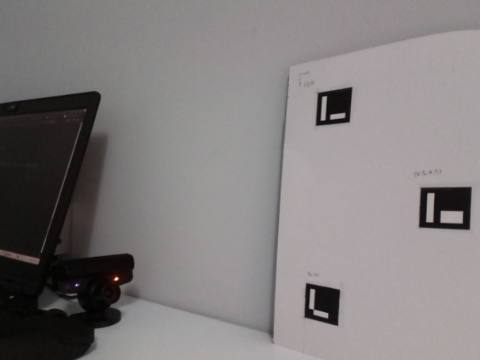

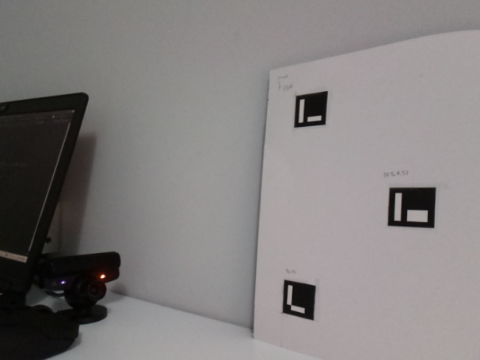

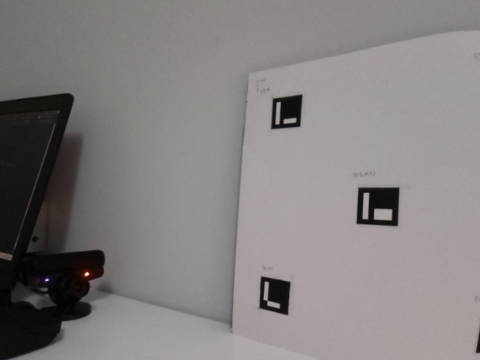

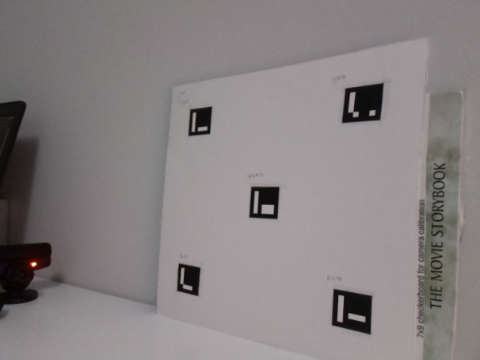

In [9]:
for i in imgs:
    disp_img(i)

# Load Camera Matrix

In [10]:
os.chdir("../../../")
print(os.getcwd())

/home/abhi/Code/3D-Scanner/res/pose_samples/blank_plane
/home/abhi/Code/3D-Scanner


In [11]:
with np.load('res/cal_out/cam_params.npz') as X:
    camera_matrix, dist_coeffs = [X[i] for i in ('mtx','dist')]

# Get pose of an image

In [15]:
def customAruco():
    # define an empty custom dictionary with 
    aruco_dict = cv2.aruco.custom_dictionary(0, 5, 1)
    # add empty bytesList array to fill with 3 markers later
    aruco_dict.bytesList = np.empty(shape = (5, 4, 4), dtype = np.uint8)
    # add new marker(s)
    mybits = np.array([[1,0,0,0,0],[1,0,0,0,0],[1,0,0,0,0],[1,0,0,0,0],[1,0,1,1,1]], dtype = np.uint8)
    aruco_dict.bytesList[0] = cv2.aruco.Dictionary_getByteListFromBits(mybits)
    mybits = np.array([[1,0,0,0,0],[1,0,0,0,0],[1,0,0,0,0],[1,0,0,0,0],[0,1,0,0,1]], dtype = np.uint8)
    aruco_dict.bytesList[1] = cv2.aruco.Dictionary_getByteListFromBits(mybits)
    mybits = np.array([[1,0,0,0,0],[1,0,0,0,0],[1,0,0,0,0],[1,0,0,0,0],[0,1,1,1,0]], dtype = np.uint8)
    aruco_dict.bytesList[2] = cv2.aruco.Dictionary_getByteListFromBits(mybits)
    mybits = np.array([[1,0,0,0,0],[1,0,0,0,0],[1,0,0,0,0],[1,0,1,1,1],[1,0,0,0,0]], dtype = np.uint8)
    aruco_dict.bytesList[3] = cv2.aruco.Dictionary_getByteListFromBits(mybits)
    mybits = np.array([[1,0,0,0,0],[1,0,0,0,0],[1,0,0,0,0],[1,0,1,1,1],[1,0,1,1,1]], dtype = np.uint8)
    aruco_dict.bytesList[4] = cv2.aruco.Dictionary_getByteListFromBits(mybits)
    # adjust dictionary parameters for better marker detection
    parameters =  cv2.aruco.DetectorParameters_create()
    parameters.cornerRefinementMethod = 3
    parameters.errorCorrectionRate = 0.2
    return aruco_dict, parameters

In [29]:
frame = imgs[0]

In [30]:
aruco_dict, arucoParams = customAruco()

In [31]:
h,w = frame.shape[:2]
new_mtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix,dist_coeffs,(w,h),1,(w,h))

In [32]:
frame = undistort_camera(frame, camera_matrix, new_mtx, roi, dist_coeffs, w, h)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [33]:
corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict, parameters=arucoParams)

In [45]:
frame_rvecs = []
frame_tvecs = []

for i in range(0, len(ids)):  
    rvec, tvec, markerPoints = cv2.aruco.estimatePoseSingleMarkers(corners[i], 3, new_mtx, dist_coeffs)
    frame_rvecs.append(rvec)
    frame_tvecs.append(tvec)
    cv2.aruco.drawDetectedMarkers(frame, corners, ids)
    cv2.aruco.drawAxis(frame, new_mtx, dist_coeffs, rvec, tvec, 0.001)

In [46]:
disp_img(frame)

In [40]:
print(frame_tvecs[0])
print(frame_tvecs[1])
print(frame_tvecs[0] - frame_tvecs[1])

[[[ 9.42351195  6.48199096 26.18034534]]]
[[[ 9.22355676 -6.95891611 22.36263542]]]
[[[ 0.19995518 13.44090707  3.81770991]]]
